1. PCA on thin section channels to find best channels for mineral identification
2. RGB image compilation
3. Training dataset creation (binary image masking)
4. Make a pandas training and testing dataset. 
5. Train models

    Clustering: 
        Characterize distributions of elements in different clusters (compare with unclustered distributions)


How unbalanced is our dataset? How many of each class are available in our dataset?

# Create a data structure


|Index #| Pixel_Coordinates | Feature_Vector            | Label           | Metadata_Pixel        | Metadata_Dataset        |
|--|-------------------:|---------------------------|-----------------|------------------------|-------------------------|
|0| (x1, y1, z1)       | [feature_vector1]         | [label1]        | (metadata1_pixel)      | {Metadata_Dataset}      |
|1| (x2, y2, z2)       | [feature_vector2]         | [label2]        | (metadata2_pixel)      | {Metadata_Dataset}      |
|...| ...               | ...                       | ...             | ...                    | ...                     |


In [97]:
import numpy as np
import pandas as pd

# Assuming the following lists are available after processing
pixel_coordinates = [(x1, y1, z1), (x2, y2, z2), ...]  # List of 3D coordinates
feature_vectors = [feature_vector1, feature_vector2, ...]  # List of feature vectors for each pixel
labels = [label1, label2, ...]  # List of labels for each pixel
metadata_pixel = [(metadata1_pixel), (metadata2_pixel), ...]  # List of metadata for each pixel
metadata_dataset = {...}  # Metadata for the entire dataset

# Create a DataFrame
df = pd.DataFrame({
    'Pixel_Coordinates': pixel_coordinates,
    'Feature_Vector': feature_vectors,
    'Label': labels,
    'Metadata_Pixel': metadata_pixel
})

# Add additional metadata for the entire dataset
df['Metadata_Dataset'] = metadata_dataset

# Display the DataFrame
print(df.head())


NameError: name 'x1' is not defined

1. Initialize a Pandas dataframe
2. Load each .tif as a numpy array and append it as a Pandas Series.
    2.1 channels (grayscale) (.tif)
    2.2 masks (binary) (.tif)
    2.3 mineral_type (strings)
    2.4 element_type (strings from filenames)
3. Combine the masks and channels to create a labelled dataset.

The dataset is created as a pandas DataFrame for each thin section, which can then be combined into an xarray. 
|Metadata|x-coords|y-coords|Ch1|Ch2|...|Ch9|Ch10|mask_A|mask_B|
|---|---|---|---|---|---|---|---|---|---|
|- Thin section name, element names, mineral phases | 1D array|1D array|2D array|2D array|...|2D array|2D array|2D array|2D array|



Import packages.

In [98]:
import pandas as pd
import numpy as np
import rasterio
import os
from PIL import Image


Load tiffs and filenames in, process, and insert into a thin section dataframe. 

In [96]:
# let's first get lists of all the thin sections, the channels, and the masks we'll need to access:

datafolder = './Aikin_Data'

# create a list of all folder names in the data folder except '.DS_Store/'
tsNames = sorted([entry for entry in os.listdir(datafolder) 
                if os.path.isdir(os.path.join(datafolder, entry)) and 'DS_Store' not in entry])
print(tsNames)
# initiate a list of thin section stacks
thinSectionStacks = []

# now we can use the names list to open the files and the stacks list to store them. 
#for each thin section folder:
for ts in range(len(tsNames)):
    this_tsName = tsNames[ts]

    # list all the filenames of maps and masks in the thin section folder
    mapNames = sorted([entry for entry in os.listdir(os.path.join(datafolder, this_tsName, 'RAW'))
                if 'DS_Store' not in entry])
    maskNames = sorted([entry for entry in os.listdir(os.path.join(datafolder, this_tsName, 'masks'))
                if 'DS_Store' not in entry])

    # apply text extraction to the mapNames to get the element names. 
    elementNames = []
    for mapName in mapNames:
        text = mapName
        filterList = 'UGG-W3-87.7-10.1-Full_', 'UGG-W3-78.7-10-',  'CC-84.7-R21-NA2-1_full_', 'CC-84.7-NA2.2_'
        filter_str = filterList[ts]
        index = text.find(filter_str)
        extracted_str = text[index + len(filter_str): index + len(filter_str) + 2]
        elementNames = np.append(elementNames, extracted_str)
            

    # apply text extraction to the maskNames to get the mineral names.
    mineralNames = []
    for maskName in maskNames:
        text = maskName
        filterList = 'garnet', 'Garnet', 'kspar', 'Kspar', 'Staurolite', 'staurolite'
        for filter_str in filterList:
            if filter_str in text:
                mineralNames = np.append(mineralNames, filter_str.capitalize())
                

    #initialize a list to store all the stacks being loaded
    thinSectionStacks.append(dict({'thin_section': this_tsName}))

    # for each map, load the file, turn it into an array, and append it 
    for map in range(len(mapNames)):
        filename = mapNames[map]
        rootfolder = os.path.join('./Aikin_Data', this_tsName, 'RAW')
        single_tsMap = Image.open(os.path.join(rootfolder, filename))
        single_mapArray = np.asarray(single_tsMap)
        columnName = str(elementNames[map]) + ' map'
        thinSectionStacks[ts][columnName] = single_mapArray
        #print(thinSectionStacks[ts][filename])


    for mask in range(len(maskNames)):
        filename = maskNames[mask]
        rootfolder = os.path.join('./Aikin_Data', this_tsName, 'masks')
        single_tsMask = Image.open(os.path.join(rootfolder, filename))
        single_maskArray = np.asarray(single_tsMask)
        columnName = str(mineralNames[mask]) + ' mask'
        thinSectionStacks[ts][columnName] = single_maskArray
    
    # Get the shape of the stack where z is the stacking dimension
    for ts in thinSectionStacks:
        print(ts.values)
        ts_Stack = np.stack(ts.values())
        print(ts_Stack)
        x,y = single_mapArray.shape
    z = len(mapNames)
    # create a coordinate grid of the same size
    coordinates = np.indices((x,y,z))
    print('coords:', coordinates[0])
    # reshape coordinates to have a list of (x, y, z) tuples
    pixel_coordinates = np.column_stack([coordinates[0].ravel(), coordinates[1].ravel(), coordinates[2].ravel()])

# Display the first few rows of the coordinates
#print(pixel_coordinates[:10])
#print(thinSectionStacks)

['78.7-10-1_Hot', '78.7-10-2_Hot', '84.7-NA-2-1_Cold', '84.7-NA2-2_Cold']
<PIL.TiffImagePlugin.TiffImageFile image mode=P size=1152x695 at 0x139F62460>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
<PIL.TiffImagePlugin.TiffImageFile image mode=P size=1152x695 at 0x139F62C40>
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
<built-in method values of dict object at 0x106882100>


TypeError: arrays to stack must be passed as a "sequence" type such as list or tuple.

We now have a LIST containing a DICTIONARY for each thin section. Each DICTIONARY contains a thin_section key, and a key for each channel and mask, using their respective filenames. 


Next, we'll want to consolidate the pixels identified in mineral masks into a Series for each mineral.

We take a copy of a stack of elemental maps and multiply each channel by the same mask; this turns all unmasked pixels into 0's and leaves the rest.
Then we reshape the array into a 1D array and append it as a DataSeries.

In [63]:
# work on this next
for ts in range(len(tsNames)):      
    mask = df['map: ' + str(filename) 
    pd.DataSeries()


SyntaxError: invalid syntax (4000197759.py, line 4)

Now, we want to turn this into a set of four pandas DataFrames, and then put those into an xarray. 

We can now store the dataframes in a list.

In [65]:
dfs = []

for ts in range(len(thinSectionStacks)):
    thin_section_data = [thinSectionStacks[ts]]
    df = pd.DataFrame(thin_section_data)
    dfs.append(df)
dfs[0].head()

,thin_section,Almap,Camap,Cemap,Femap,K map,Mgmap,Timap,Y map,Zrmap,llmap,Garnetmask,Ksparmask
0,78.7-10-1_Hot,"[[81.0, 90.0, 72.0, 109.0, 103.0, 94.0, 93.0, ...","[[48.0, 47.0, 49.0, 46.0, 33.0, 47.0, 44.0, 33...","[[5.0, 4.0, 7.0, 3.0, 3.0, 0.0, 3.0, 1.0, 2.0,...","[[20.0, 20.0, 21.0, 19.0, 16.0, 10.0, 11.0, 19...","[[43.0, 47.0, 40.0, 55.0, 39.0, 45.0, 41.0, 46...","[[4.0, 1.0, 1.0, 9.0, 5.0, 6.0, 6.0, 5.0, 6.0,...","[[3.0, 3.0, 4.0, 3.0, 5.0, 3.0, 4.0, 2.0, 2.0,...","[[19.0, 13.0, 11.0, 20.0, 13.0, 21.0, 21.0, 19...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0,...","[[93.0, 90.0, 97.0, 83.0, 82.0, 86.0, 79.0, 77...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


Now we have the basic structure for our data, but it still needs some metadata and a good bit of cleanup. 

Pixel coordinates

In [77]:
df = dfs[0]
df.head()
df.iloc[:, 1][0].shape

(695, 1152)

In [80]:
# Get the shape of the stack where z is the stacking dimension
for df in dfs:
    x,y,z = df.iloc[:, 1:][0].shape
    # create a coordinate grid of the same size
    coordinates = np.indices((x,y,z))
    print(coordinates)
    # reshape coordinates to have a list of (x, y, z) tuples
pixel_coordinates = np.column_stack([coordinates[0].ravel(), coordinates[1].ravel(), coordinates[2].ravel()])

# Display the first few rows of the coordinates
print(pixel_coordinates[:10])

KeyError: 0

In [4]:
# PCA

# Import useful modules
import requests, zipfile, io, gzip, glob, os
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as ln
import pandas as pd
import matplotlib
from matplotlib import cm
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn import datasets
import sklearn



In [4]:
# Feature selection via parameter exploration

# Heatmap functions
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

'.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n                \n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n    ============== ==== =

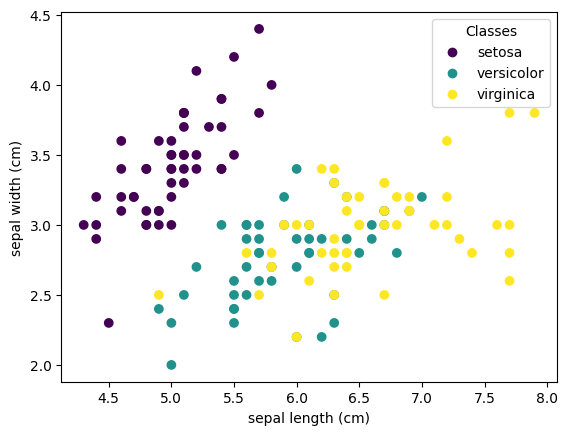

In [19]:
# Let's load in the iris dataset
iris = datasets.load_iris()

# Convert iris to a pandas dataframe...
irisDF = pd.DataFrame(data=iris.data,  
                  columns=iris.feature_names)

# Now, plot up sepal length vs width, color-coded by target (or species)

scatter = plt.scatter(irisDF['sepal length (cm)'], irisDF['sepal width (cm)'], c=iris.target)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend(scatter.legend_elements()[0], iris.target_names, title="Classes")


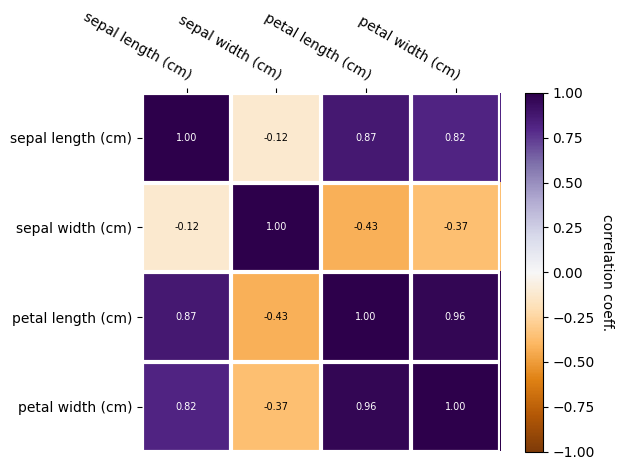

In [24]:
# Now, how might we reduce these dimensions? 
# One way is by looking at how variables are correlated
# Calculate the correlation coefficients for all variables
allCorr = irisDF.corr()

im, _ = heatmap(allCorr, irisDF, irisDF,
                cmap="PuOr", vmin=-1, vmax=1,
                cbarlabel="correlation coeff.")

annotate_heatmap(im, size=7)

plt.tight_layout()
plt.show()


In [21]:
allCorr

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


Aiman's random forest code

In [103]:
from PIL import Image
from skimage import io, color, filters
import matplotlib.pyplot as plt

# Load the grayscale image
grayscale_image_path = './Aikin_Data/78.7-10-1_Hot/masks/78.7-10-1_Hot_FeTiZr_garnet_mask.tif'
grayscale_image = Image.open(grayscale_image_path)

# Convert the image to a valid data type (float or uint8)
single_mapArray = np.asarray(single_tsMap)
# Apply thresholding
threshold_value = filters.threshold_otsu(grayscale_image)
binary_image = (grayscale_image > threshold_value).astype(np.uint8)

# Display the original and binary images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(grayscale_image, cmap='gray')
axes[0].set_title('Original Grayscale Image')

axes[1].imshow(binary_image, cmap='binary')
axes[1].set_title('Binary Image')

plt.show()

ModuleNotFoundError: No module named 'skimage'